# Install and Import Dependencies

In [5]:
!pip install --upgrade --no-cache-dir gdown
!gdown 19RUUfXoiHARAEP3Xh8cZxoH87Mo0owsw -O teleCust1000t.csv

!git clone https://github.com/iShohei220/adopt.git
!pip install -r adopt/requirements.txt
!pip install torch seaborn matplotlib scikit-learn

import sys
sys.path.append('/content/adopt')  # Adjust path if needed

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Downloading...
From: https://drive.google.com/uc?id=19RUUfXoiHARAEP3Xh8cZxoH87Mo0owsw
To: /content/teleCust1000t.csv
100% 37.0k/37.0k [00:00<00:00, 66.5MB/s]
fatal: destination path 'adopt' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'adopt/requirements.txt'


Set random seeds for reproducibility

In [6]:
np.random.seed(8)
torch.manual_seed(8)

Load and Inspect Data

In [7]:
data = pd.read_csv('teleCust1000t.csv')
print("Data Info:")
print(data.info())
print("\nData Description:")
print(data.describe())
print("\nData Head:")
print(data.head())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   int64  
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   int64  
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   int64  
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB
None

Data Description:
          region       tenure          age      marital      address  \
count  1000.0000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      2.0220    35.526000    41.684000     0.495000    11.551000   
std       0.8162    21.359812    12.558816     0.500225    

 Correlation Analysis and Plotting

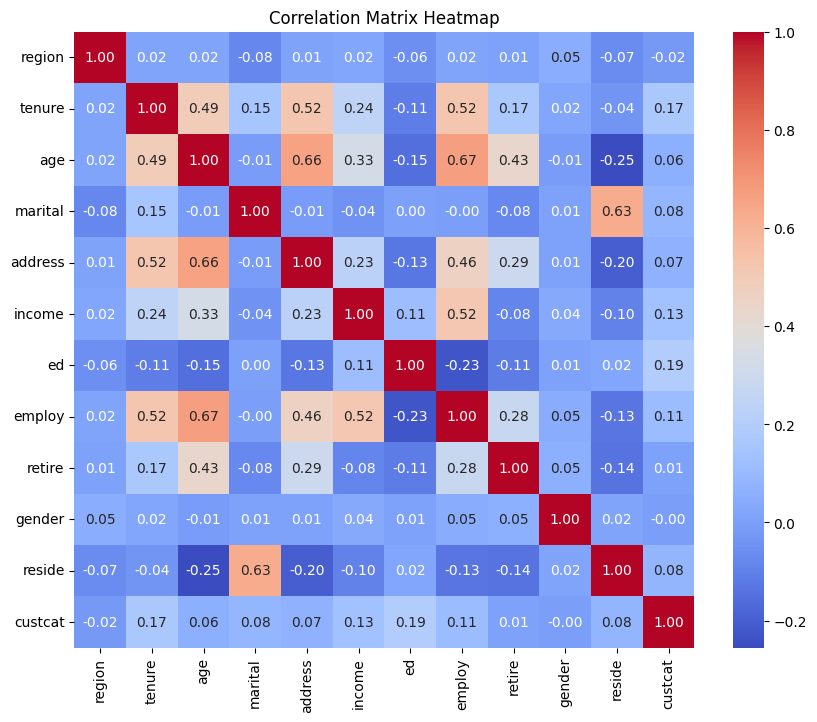

Correlation of features with 'custcat':
 custcat    1.000000
ed         0.193864
tenure     0.166691
income     0.134525
employ     0.110011
marital    0.083836
reside     0.082022
address    0.067913
age        0.056909
retire     0.008908
gender    -0.004966
region    -0.023771
Name: custcat, dtype: float64


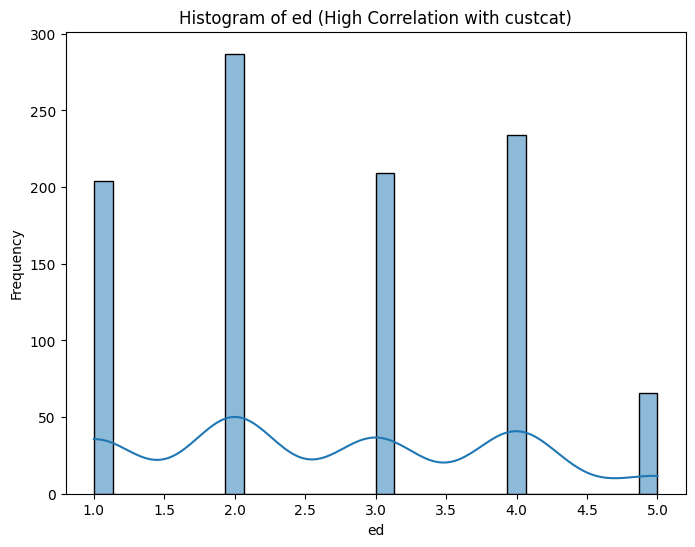

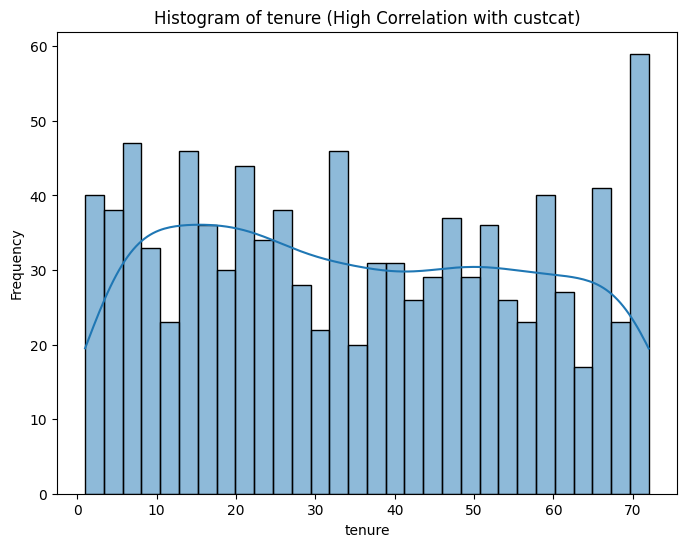

In [16]:
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

target_correlation = correlation_matrix['custcat'].sort_values(ascending=False)
print("Correlation of features with 'custcat':\n", target_correlation)

top_features = target_correlation[1:3].index
for feature in top_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Histogram of {feature} (High Correlation with custcat)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

 Data Preprocessing

Normalize and Split into Train/Validation/Test

In [37]:
X = data.drop(columns=['custcat']).values
y = (data['custcat'] - 1).values  # from [1,4] to [0,3]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3,
                                                    random_state=8, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                random_state=8, stratify=y_temp)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)
input_dim = X_train.shape[1]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Shapes:
X_train: (700, 11) y_train: (700,)
X_val: (150, 11) y_val: (150,)
X_test: (150, 11) y_test: (150,)


# Model Definition Function

In [38]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=1, neurons=32, batch_norm=False,
                 dropout_rate=0.0, num_classes=4):
        super(MLP, self).__init__()
        layers = []
        in_dim = input_dim
        for i in range(hidden_layers):
            layers.append(nn.Linear(in_dim, neurons))
            layers.append(nn.ReLU())
            if batch_norm:
                layers.append(nn.BatchNorm1d(neurons))
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            in_dim = neurons
        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Training and Evaluation Functions

In [39]:
def train_model(model, optimizer, train_loader, val_loader, epochs=100, patience=10, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    best_state_dict = None

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*Xb.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == yb).sum().item()
            total += Xb.size(0)

        train_acc = train_correct / total
        val_loss, val_acc = evaluate_model(model, val_loader, device=device)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/total:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # restore best weights
    model.load_state_dict(best_state_dict)
    return model

def evaluate_model(model, data_loader, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    model.to(device)
    loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for Xb, yb in data_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            outputs = model(Xb)
            l = criterion(outputs, yb)
            loss += l.item()*Xb.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == yb).sum().item()
            total += Xb.size(0)
    return loss/total, correct/total

def test_accuracy(model, test_loader, device='cpu'):
    _, acc = evaluate_model(model, test_loader, device=device)
    return acc

Helper to directly train and evaluate a model configuration

In [40]:
def train_and_test(hidden_layers=1, neurons=32, batch_norm=False, dropout_rate=0.0,
                   l2_reg=0.0, optimizer_type='SGD', lr=0.01, epochs=100, patience=10,
                   device='cpu'):
    model = MLP(input_dim, hidden_layers, neurons, batch_norm, dropout_rate)
    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_reg)
    elif optimizer_type == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=l2_reg)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
    elif optimizer_type == 'ADOPT':
        optimizer = ADOPT(model.parameters(), lr=lr, weight_decay=l2_reg)
    else:
        raise ValueError("Unknown optimizer type")

    model = train_model(model, optimizer, train_loader, val_loader, epochs, patience, device=device)
    acc = test_accuracy(model, test_loader, device=device)
    return model, acc

Impact of Number of Neurons with 1 Hidden Layer

In [41]:
configurations_neurons = [16, 32, 64]
results_neurons = []
for n in configurations_neurons:
    print(f"Training model with {n} Neurons")
    _, acc = train_and_test(hidden_layers=1, neurons=n, optimizer_type='SGD', lr=0.01)
    results_neurons.append((n, acc))
    print(f"Test Accuracy with {n} neurons: {acc:.4f}\n")

# Find best neuron config
best_neurons = max(results_neurons, key=lambda x: x[1])[0]
print("Best number of neurons:", best_neurons)

Training model with 16 Neurons
Epoch 1/100, Train Loss: 1.3924, Train Acc: 0.2400, Val Loss: 1.3905, Val Acc: 0.2267
Epoch 2/100, Train Loss: 1.3909, Train Acc: 0.2443, Val Loss: 1.3894, Val Acc: 0.2400
Epoch 3/100, Train Loss: 1.3896, Train Acc: 0.2500, Val Loss: 1.3883, Val Acc: 0.2600
Epoch 4/100, Train Loss: 1.3885, Train Acc: 0.2557, Val Loss: 1.3874, Val Acc: 0.2467
Epoch 5/100, Train Loss: 1.3874, Train Acc: 0.2643, Val Loss: 1.3866, Val Acc: 0.2933
Epoch 6/100, Train Loss: 1.3864, Train Acc: 0.2671, Val Loss: 1.3859, Val Acc: 0.3000
Epoch 7/100, Train Loss: 1.3855, Train Acc: 0.2629, Val Loss: 1.3852, Val Acc: 0.3000
Epoch 8/100, Train Loss: 1.3846, Train Acc: 0.2757, Val Loss: 1.3846, Val Acc: 0.3000
Epoch 9/100, Train Loss: 1.3839, Train Acc: 0.2786, Val Loss: 1.3840, Val Acc: 0.3000
Epoch 10/100, Train Loss: 1.3831, Train Acc: 0.2900, Val Loss: 1.3834, Val Acc: 0.3000
Epoch 11/100, Train Loss: 1.3825, Train Acc: 0.2957, Val Loss: 1.3829, Val Acc: 0.2933
Epoch 12/100, Train L

Add Batch Normalization

In [42]:
print("Training with Batch Normalization:")
_, acc_bn = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=True, optimizer_type='SGD')
print(f"Accuracy with BatchNorm: {acc_bn:.4f}")

# Compare to no BN
_, acc_no_bn = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=False, optimizer_type='SGD')
print(f"Accuracy without BatchNorm: {acc_no_bn:.4f}")

Training with Batch Normalization:
Epoch 1/100, Train Loss: 1.4472, Train Acc: 0.2800, Val Loss: 1.3801, Val Acc: 0.3067
Epoch 2/100, Train Loss: 1.3902, Train Acc: 0.3100, Val Loss: 1.3574, Val Acc: 0.3200
Epoch 3/100, Train Loss: 1.3533, Train Acc: 0.3257, Val Loss: 1.3379, Val Acc: 0.3133
Epoch 4/100, Train Loss: 1.3254, Train Acc: 0.3500, Val Loss: 1.3197, Val Acc: 0.3333
Epoch 5/100, Train Loss: 1.3151, Train Acc: 0.3586, Val Loss: 1.3039, Val Acc: 0.3400
Epoch 6/100, Train Loss: 1.3010, Train Acc: 0.3814, Val Loss: 1.2938, Val Acc: 0.3600
Epoch 7/100, Train Loss: 1.2959, Train Acc: 0.3714, Val Loss: 1.2847, Val Acc: 0.3933
Epoch 8/100, Train Loss: 1.2833, Train Acc: 0.3786, Val Loss: 1.2778, Val Acc: 0.3600
Epoch 9/100, Train Loss: 1.2701, Train Acc: 0.3929, Val Loss: 1.2715, Val Acc: 0.3867
Epoch 10/100, Train Loss: 1.2641, Train Acc: 0.4014, Val Loss: 1.2660, Val Acc: 0.3800
Epoch 11/100, Train Loss: 1.2706, Train Acc: 0.4100, Val Loss: 1.2619, Val Acc: 0.3667
Epoch 12/100, Tra

Add Dropout

In [43]:
dropout_rate = 0.5
_, acc_dropout = train_and_test(hidden_layers=1, neurons=best_neurons, dropout_rate=dropout_rate, optimizer_type='SGD')
print(f"Accuracy with Dropout: {acc_dropout:.4f}")

Epoch 1/100, Train Loss: 1.3926, Train Acc: 0.2486, Val Loss: 1.3921, Val Acc: 0.2400
Epoch 2/100, Train Loss: 1.4025, Train Acc: 0.2243, Val Loss: 1.3902, Val Acc: 0.2400
Epoch 3/100, Train Loss: 1.3926, Train Acc: 0.2486, Val Loss: 1.3888, Val Acc: 0.2600
Epoch 4/100, Train Loss: 1.3940, Train Acc: 0.2571, Val Loss: 1.3877, Val Acc: 0.2600
Epoch 5/100, Train Loss: 1.3901, Train Acc: 0.2357, Val Loss: 1.3866, Val Acc: 0.2600
Epoch 6/100, Train Loss: 1.3858, Train Acc: 0.2400, Val Loss: 1.3857, Val Acc: 0.2400
Epoch 7/100, Train Loss: 1.3904, Train Acc: 0.2543, Val Loss: 1.3849, Val Acc: 0.2400
Epoch 8/100, Train Loss: 1.3853, Train Acc: 0.2329, Val Loss: 1.3843, Val Acc: 0.2800
Epoch 9/100, Train Loss: 1.3895, Train Acc: 0.2714, Val Loss: 1.3837, Val Acc: 0.2867
Epoch 10/100, Train Loss: 1.3853, Train Acc: 0.2671, Val Loss: 1.3832, Val Acc: 0.2667
Epoch 11/100, Train Loss: 1.3830, Train Acc: 0.2429, Val Loss: 1.3826, Val Acc: 0.2800
Epoch 12/100, Train Loss: 1.3827, Train Acc: 0.2743,

 Add L2 Regularization

In [44]:
l2_rate = 0.0001
_, acc_l2 = train_and_test(hidden_layers=1, neurons=best_neurons, l2_reg=l2_rate, optimizer_type='SGD')
print(f"Accuracy with L2 Regularization: {acc_l2:.4f}")

# Combine BN + Dropout + L2
_, acc_combined = train_and_test(hidden_layers=1, neurons=best_neurons,
                                 batch_norm=True, dropout_rate=0.5, l2_reg=0.0001,
                                 optimizer_type='SGD', lr=0.01)
print(f"Accuracy with BN+Dropout+L2: {acc_combined:.4f}")

Epoch 1/100, Train Loss: 1.3876, Train Acc: 0.2629, Val Loss: 1.3871, Val Acc: 0.2400
Epoch 2/100, Train Loss: 1.3860, Train Acc: 0.2600, Val Loss: 1.3860, Val Acc: 0.2533
Epoch 3/100, Train Loss: 1.3846, Train Acc: 0.2643, Val Loss: 1.3850, Val Acc: 0.2400
Epoch 4/100, Train Loss: 1.3835, Train Acc: 0.2671, Val Loss: 1.3842, Val Acc: 0.2600
Epoch 5/100, Train Loss: 1.3825, Train Acc: 0.2743, Val Loss: 1.3836, Val Acc: 0.2933
Epoch 6/100, Train Loss: 1.3815, Train Acc: 0.2743, Val Loss: 1.3830, Val Acc: 0.3133
Epoch 7/100, Train Loss: 1.3808, Train Acc: 0.2914, Val Loss: 1.3825, Val Acc: 0.3067
Epoch 8/100, Train Loss: 1.3800, Train Acc: 0.2843, Val Loss: 1.3821, Val Acc: 0.3067
Epoch 9/100, Train Loss: 1.3794, Train Acc: 0.2814, Val Loss: 1.3817, Val Acc: 0.2933
Epoch 10/100, Train Loss: 1.3787, Train Acc: 0.2914, Val Loss: 1.3814, Val Acc: 0.2733
Epoch 11/100, Train Loss: 1.3782, Train Acc: 0.3014, Val Loss: 1.3810, Val Acc: 0.2867
Epoch 12/100, Train Loss: 1.3776, Train Acc: 0.3029,

 Different Optimizers (RMSprop, Adam)

In [46]:
# RMSprop
_, acc_rms = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=True, dropout_rate=0.5, l2_reg=0.0001,
                            optimizer_type='RMSprop', lr=0.001)
print(f"Accuracy with RMSprop: {acc_rms:.4f}")

# Adam
_, acc_adam = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=True, dropout_rate=0.5, l2_reg=0.0001,
                             optimizer_type='Adam', lr=0.001)
print(f"Accuracy with Adam: {acc_adam:.4f}")

Epoch 1/100, Train Loss: 1.4957, Train Acc: 0.2529, Val Loss: 1.3963, Val Acc: 0.2800
Epoch 2/100, Train Loss: 1.4370, Train Acc: 0.2643, Val Loss: 1.4010, Val Acc: 0.2933
Epoch 3/100, Train Loss: 1.4207, Train Acc: 0.2900, Val Loss: 1.3996, Val Acc: 0.2933
Epoch 4/100, Train Loss: 1.3759, Train Acc: 0.3386, Val Loss: 1.3921, Val Acc: 0.3000
Epoch 5/100, Train Loss: 1.3582, Train Acc: 0.3371, Val Loss: 1.3895, Val Acc: 0.3067
Epoch 6/100, Train Loss: 1.3807, Train Acc: 0.3186, Val Loss: 1.3983, Val Acc: 0.3067
Epoch 7/100, Train Loss: 1.3621, Train Acc: 0.3214, Val Loss: 1.3730, Val Acc: 0.3467
Epoch 8/100, Train Loss: 1.3496, Train Acc: 0.3529, Val Loss: 1.3669, Val Acc: 0.3333
Epoch 9/100, Train Loss: 1.3349, Train Acc: 0.3600, Val Loss: 1.3575, Val Acc: 0.3733
Epoch 10/100, Train Loss: 1.3393, Train Acc: 0.3600, Val Loss: 1.3525, Val Acc: 0.3800
Epoch 11/100, Train Loss: 1.3572, Train Acc: 0.3371, Val Loss: 1.3453, Val Acc: 0.3667
Epoch 12/100, Train Loss: 1.3192, Train Acc: 0.3729,

 Impact of Number of Neurons with 2 Hidden Layer

In [47]:
configurations_neurons_2_layer = [16, 32, 64]
results_neurons_2_layer = []
for n in configurations_neurons_2_layer:
    print(f"Training 2-Layer model with {n} Neurons")
    _, acc = train_and_test(hidden_layers=2, neurons=n, optimizer_type='SGD', lr=0.01, batch_norm=True)
    results_neurons_2_layer.append((n, acc))
    print(f"Test Accuracy with 2 layers and {n} neurons: {acc:.4f}\n")

# Find best neuron config for 2 layers
best_neurons_2_layer = max(results_neurons_2_layer, key=lambda x: x[1])[0]
print("Best neuron configuration for 2 hidden layers:", best_neurons_2_layer)

Training 2-Layer model with 16 Neurons
Epoch 1/100, Train Loss: 1.4067, Train Acc: 0.2929, Val Loss: 1.3898, Val Acc: 0.3067
Epoch 2/100, Train Loss: 1.3760, Train Acc: 0.3314, Val Loss: 1.3591, Val Acc: 0.3000
Epoch 3/100, Train Loss: 1.3434, Train Acc: 0.3457, Val Loss: 1.3459, Val Acc: 0.3067
Epoch 4/100, Train Loss: 1.3290, Train Acc: 0.3700, Val Loss: 1.3270, Val Acc: 0.3333
Epoch 5/100, Train Loss: 1.3031, Train Acc: 0.3943, Val Loss: 1.3200, Val Acc: 0.3800
Epoch 6/100, Train Loss: 1.3171, Train Acc: 0.3814, Val Loss: 1.3177, Val Acc: 0.3667
Epoch 7/100, Train Loss: 1.2962, Train Acc: 0.3971, Val Loss: 1.3051, Val Acc: 0.3600
Epoch 8/100, Train Loss: 1.2806, Train Acc: 0.3929, Val Loss: 1.3074, Val Acc: 0.3333
Epoch 9/100, Train Loss: 1.2874, Train Acc: 0.3986, Val Loss: 1.3011, Val Acc: 0.3267
Epoch 10/100, Train Loss: 1.2680, Train Acc: 0.3943, Val Loss: 1.2975, Val Acc: 0.3400
Epoch 11/100, Train Loss: 1.2606, Train Acc: 0.4186, Val Loss: 1.2977, Val Acc: 0.3333
Epoch 12/100,

 Add Dropout

In [48]:
dropout_rate = 0.5
_, acc_dropout_2_layer = train_and_test(hidden_layers=2, neurons=best_neurons_2_layer, dropout_rate=dropout_rate, optimizer_type='SGD')
print(f"Accuracy with Dropout (2 layers, rate={dropout_rate}): {acc_dropout_2_layer:.4f}")

Epoch 1/100, Train Loss: 1.4137, Train Acc: 0.2357, Val Loss: 1.4120, Val Acc: 0.2333
Epoch 2/100, Train Loss: 1.4127, Train Acc: 0.2357, Val Loss: 1.4077, Val Acc: 0.2333
Epoch 3/100, Train Loss: 1.4093, Train Acc: 0.2357, Val Loss: 1.4042, Val Acc: 0.2333
Epoch 4/100, Train Loss: 1.4032, Train Acc: 0.2357, Val Loss: 1.4012, Val Acc: 0.2333
Epoch 5/100, Train Loss: 1.3960, Train Acc: 0.2357, Val Loss: 1.3987, Val Acc: 0.2333
Epoch 6/100, Train Loss: 1.3979, Train Acc: 0.2414, Val Loss: 1.3965, Val Acc: 0.2333
Epoch 7/100, Train Loss: 1.3937, Train Acc: 0.2314, Val Loss: 1.3946, Val Acc: 0.2333
Epoch 8/100, Train Loss: 1.3932, Train Acc: 0.2314, Val Loss: 1.3930, Val Acc: 0.2333
Epoch 9/100, Train Loss: 1.3943, Train Acc: 0.2457, Val Loss: 1.3915, Val Acc: 0.2333
Epoch 10/100, Train Loss: 1.3934, Train Acc: 0.2414, Val Loss: 1.3902, Val Acc: 0.2333
Epoch 11/100, Train Loss: 1.3925, Train Acc: 0.2486, Val Loss: 1.3891, Val Acc: 0.2333
Epoch 12/100, Train Loss: 1.3899, Train Acc: 0.2371,

 Add L2 Regularization

In [49]:
l2_rate = 0.0001
_, acc_l2_2_layer = train_and_test(hidden_layers=2, neurons=best_neurons_2_layer, l2_reg=l2_rate, optimizer_type='SGD')
print(f"Accuracy with L2 Regularization (2 layers, l2={l2_rate}): {acc_l2_2_layer:.4f}")

Epoch 1/100, Train Loss: 1.3972, Train Acc: 0.2814, Val Loss: 1.3976, Val Acc: 0.2800
Epoch 2/100, Train Loss: 1.3949, Train Acc: 0.2814, Val Loss: 1.3956, Val Acc: 0.2800
Epoch 3/100, Train Loss: 1.3930, Train Acc: 0.2814, Val Loss: 1.3938, Val Acc: 0.2800
Epoch 4/100, Train Loss: 1.3914, Train Acc: 0.2814, Val Loss: 1.3922, Val Acc: 0.2800
Epoch 5/100, Train Loss: 1.3898, Train Acc: 0.2814, Val Loss: 1.3908, Val Acc: 0.2800
Epoch 6/100, Train Loss: 1.3886, Train Acc: 0.2814, Val Loss: 1.3896, Val Acc: 0.2800
Epoch 7/100, Train Loss: 1.3875, Train Acc: 0.2814, Val Loss: 1.3885, Val Acc: 0.2800
Epoch 8/100, Train Loss: 1.3864, Train Acc: 0.2814, Val Loss: 1.3876, Val Acc: 0.2800
Epoch 9/100, Train Loss: 1.3856, Train Acc: 0.2814, Val Loss: 1.3867, Val Acc: 0.2800
Epoch 10/100, Train Loss: 1.3847, Train Acc: 0.2814, Val Loss: 1.3860, Val Acc: 0.2800
Epoch 11/100, Train Loss: 1.3840, Train Acc: 0.2814, Val Loss: 1.3854, Val Acc: 0.2800
Epoch 12/100, Train Loss: 1.3834, Train Acc: 0.2814,

Combine BN + Dropout + L2

In [50]:
_, acc_combined_2_layer = train_and_test(
    hidden_layers=2, neurons=best_neurons_2_layer,
    batch_norm=True, dropout_rate=dropout_rate, l2_reg=l2_rate,
    optimizer_type='SGD', lr=0.01
)
print(f"Accuracy with BN+Dropout+L2 (2 layers): {acc_combined_2_layer:.4f}")

Epoch 1/100, Train Loss: 1.6506, Train Acc: 0.2357, Val Loss: 1.3972, Val Acc: 0.2400
Epoch 2/100, Train Loss: 1.5522, Train Acc: 0.2786, Val Loss: 1.3769, Val Acc: 0.2667
Epoch 3/100, Train Loss: 1.5291, Train Acc: 0.2543, Val Loss: 1.3540, Val Acc: 0.3200
Epoch 4/100, Train Loss: 1.4856, Train Acc: 0.2757, Val Loss: 1.3486, Val Acc: 0.3200
Epoch 5/100, Train Loss: 1.4258, Train Acc: 0.2757, Val Loss: 1.3434, Val Acc: 0.3533
Epoch 6/100, Train Loss: 1.4613, Train Acc: 0.2686, Val Loss: 1.3379, Val Acc: 0.3467
Epoch 7/100, Train Loss: 1.4433, Train Acc: 0.2671, Val Loss: 1.3311, Val Acc: 0.3333
Epoch 8/100, Train Loss: 1.4281, Train Acc: 0.2900, Val Loss: 1.3332, Val Acc: 0.3533
Epoch 9/100, Train Loss: 1.3693, Train Acc: 0.3314, Val Loss: 1.3260, Val Acc: 0.3267
Epoch 10/100, Train Loss: 1.3993, Train Acc: 0.2829, Val Loss: 1.3260, Val Acc: 0.3333
Epoch 11/100, Train Loss: 1.3719, Train Acc: 0.3114, Val Loss: 1.3206, Val Acc: 0.3200
Epoch 12/100, Train Loss: 1.3630, Train Acc: 0.3157,

 Different Optimizers (RMSprop, Adam) for 2 Hidden Layers

In [51]:
# RMSprop
_, acc_rms_2_layer = train_and_test(
    hidden_layers=2, neurons=best_neurons_2_layer, batch_norm=True, dropout_rate=dropout_rate, l2_reg=l2_rate,
    optimizer_type='RMSprop', lr=0.001
)
print(f"Accuracy with RMSprop (2 layers): {acc_rms_2_layer:.4f}")

# Adam
_, acc_adam_2_layer = train_and_test(
    hidden_layers=2, neurons=best_neurons_2_layer, batch_norm=True, dropout_rate=dropout_rate, l2_reg=l2_rate,
    optimizer_type='Adam', lr=0.001
)
print(f"Accuracy with Adam (2 layers): {acc_adam_2_layer:.4f}")

Epoch 1/100, Train Loss: 1.5455, Train Acc: 0.2414, Val Loss: 1.3900, Val Acc: 0.2933
Epoch 2/100, Train Loss: 1.4633, Train Acc: 0.2743, Val Loss: 1.3733, Val Acc: 0.2867
Epoch 3/100, Train Loss: 1.4311, Train Acc: 0.2957, Val Loss: 1.3582, Val Acc: 0.3000
Epoch 4/100, Train Loss: 1.4238, Train Acc: 0.2957, Val Loss: 1.3499, Val Acc: 0.3333
Epoch 5/100, Train Loss: 1.4038, Train Acc: 0.2757, Val Loss: 1.3478, Val Acc: 0.3533
Epoch 6/100, Train Loss: 1.3698, Train Acc: 0.3314, Val Loss: 1.3489, Val Acc: 0.3200
Epoch 7/100, Train Loss: 1.3690, Train Acc: 0.3286, Val Loss: 1.3438, Val Acc: 0.3333
Epoch 8/100, Train Loss: 1.3833, Train Acc: 0.3100, Val Loss: 1.3375, Val Acc: 0.3200
Epoch 9/100, Train Loss: 1.3733, Train Acc: 0.2786, Val Loss: 1.3314, Val Acc: 0.3333
Epoch 10/100, Train Loss: 1.3424, Train Acc: 0.3471, Val Loss: 1.3357, Val Acc: 0.3267
Epoch 11/100, Train Loss: 1.3543, Train Acc: 0.3257, Val Loss: 1.3366, Val Acc: 0.3667
Epoch 12/100, Train Loss: 1.3514, Train Acc: 0.3314,